In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
raw_data = yf.download("BTC-USD", start="2000-01-01")
raw_data.shape

[*********************100%***********************]  1 of 1 completed


(3140, 6)

In [3]:
raw_data.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

<Axes: xlabel='Date'>

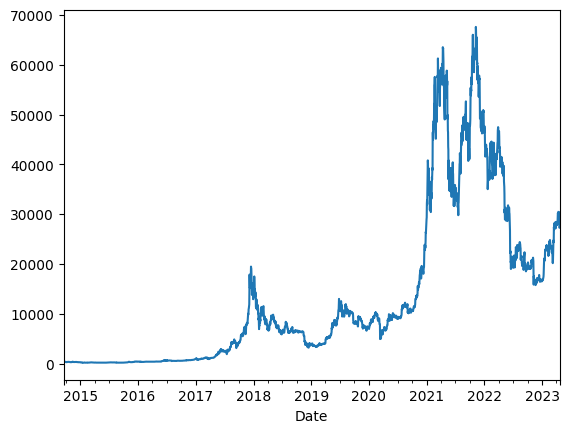

In [4]:
raw_data["Adj Close"].plot()

In [5]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(raw_data["Adj Close"].values.reshape(-1, 1))

In [6]:
def split_features(df, window_size):
    x, y = [], []
    
    for i in range(len(df) - window_size):
        row = [[a] for a in df[i : i + window_size]]
        x.append(row)
        label = df[i + window_size]
        y.append(label)

    x = np.array(x)
    x = x.reshape(x.shape[0], x.shape[1], x.shape[2])
    
    y = np.array(y)

    return x, y

In [22]:
x, y = split_features(scaled_data, 60)

In [23]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42, shuffle=False)

In [24]:
# introduce hyperparameters next 
model = Sequential()

model.add(LSTM(x_train.shape[1], return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM((x_train.shape[1] * 2), return_sequences=True)))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(x_train.shape[1], return_sequences=False)))

model.add(Dense(1))
model.add(Activation("linear"))

model.compile(optimizer="adam", loss="mse")

In [25]:
earlyStop = EarlyStopping(monitor="val_loss", patience=2)

In [30]:
history = model.fit(x_train, y_train, validation_split=0.2, epochs=10, batch_size=64, shuffle=False, callbacks=earlyStop) 

Epoch 1/10
35/35 [==============================] - 11s 303ms/step - loss: 9.4947e-04 - val_loss: 0.0069
Epoch 2/10
35/35 [==============================] - 10s 290ms/step - loss: 2.1898e-04 - val_loss: 0.0248
Epoch 3/10
35/35 [==============================] - 10s 284ms/step - loss: 5.8513e-04 - val_loss: 0.0091


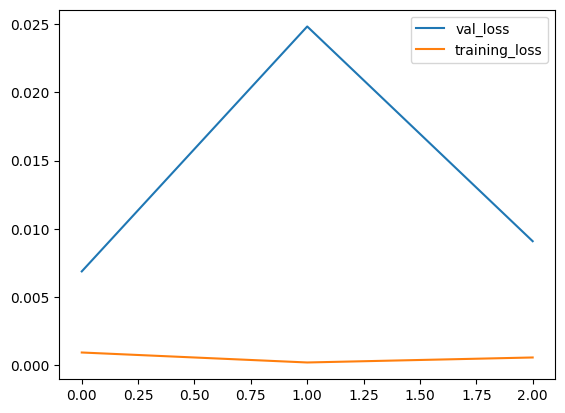

In [31]:
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot(history.history["loss"], label="training_loss")
plt.legend()

10/10 [==============================] - 0s 48ms/step


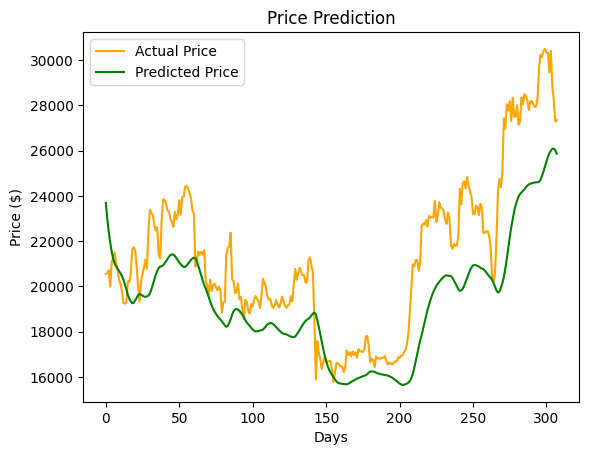

In [32]:
y_pred = model.predict(x_test)

# invert the scaler to get the absolute price data
y_test_orig = scaler.inverse_transform(y_test)
y_pred_orig = scaler.inverse_transform(y_pred)

# plots of prediction against actual data
plt.plot(y_test_orig, label='Actual Price', color='orange')
plt.plot(y_pred_orig, label='Predicted Price', color='green')
 
plt.title('Price Prediction')
plt.xlabel('Days')
plt.ylabel('Price ($)')
plt.legend(loc='best')